# Update your repository with new stuff
#### Note this is technically not good practice here, but we'll worry about that later

- Open git bash to your learning python folder

- git checkout -b session2

- git remote add upstream https://github.com/tne-lab/learning-python

- git fetch upstream

- git merge upstream/master --strategy-option theirs

### Open Jupyter Notebook and open Session_2.ipynb


# Today we will look at events first


In [2]:
import os
import OpenEphys

cwd = os.getcwd() # Gets your current working directory
pathToEvents = cwd + '\\data\\Sample_Data\\all_channels.events' # All events are stored here
 
allEvents = OpenEphys.load(pathToEvents)
print('events loaded in!')

pathToData = cwd + '\\data\\Sample_Data\\100_CH1.continuous' # You can change this to look at other channels!
 
data = OpenEphys.load(pathToData)
print('data loaded in!')

loading events...
events loaded in!
Loading continuous data...
data loaded in!


In [3]:
# What is events?
print(type(allEvents))

# Lets look at what is stored in here.
for key in allEvents.keys():
    print(key)

<class 'dict'>
header
channel
timestamps
eventType
nodeId
eventId
recordingNumber
sampleNum


In [6]:
# Lots of information here
print(allEvents['header'])
print('-')
print(allEvents['eventId']) # we'll look at this later

{'format': "'Open Ephys Data Format'", ' version': '0.4', ' header_bytes': '1024', 'description': "'each record contains one 64-bit timestamp, one 16-bit sample position, one uint8 event type, one uint8 processor ID, one uint8 event ID, one uint8 event channel, and one uint16 recordingNumber'", ' date_created': "'9-Aug-2017 105450'", 'channel': "'Rhythm FPGA source TTL events input'", 'channelType': "'Continuous'", 'sampleRate': '30000', 'blockLength': '1024', 'bufferSize': '160', 'bitVolts': '1'}
-
[1. 0. 1. ... 1. 0. 1.]


## Challenge 1
### Build a class to store event data

In [13]:
import numpy as np

class Events:
    # Put code here (use Con class below as a reference!)
    def __init__(self, data, tsStart):
        self.eventId = data['eventId']
        self.nodeId = data['nodeId']
        self.eventType = data['eventType']
        self.channel = data['channel']
        
        #timestamps?
        self.ts = []
        for ts in data['timestamps']:
            self.ts.append(ts - tsStart)
            
        # Other option
        # self.ts = data['timestamps'] - tsStart
    
class Con:
    def __init__(self, data):
        self.data = data['data'] # Volatage data
        self.fs = float(data['header']['sampleRate']) # Sample Rate
        self.interpTs(data['timestamps']) # Interpolate timestamps for all data points (Only has 1 time stamp for each buffer of 1024 data points)

    def interpTs(self, ts):
        tsStart = ts[0]
        tsEnd = ts[len(ts)-1]
        self.ts = np.linspace(tsStart, tsEnd, len(ts) * 1024) # Creates the array of timestamps
        i = 0
        for t in self.ts:
            self.ts[i] = t - tsStart # Zero out the timestamps, just makes it look better when graphing/explaining
            i = i + 1
        self.tsStart = tsStart # Send the ts start to event data
        
con = Con(data)

events = Events(allEvents, con.tsStart)
print('Classes finished!')

Classes finished!


In [14]:
print(events.ts)

[2431.0, 2531.0, 3205.0, 3337.0, 35795.0, 35895.0, 36571.0, 36697.0, 68371.0, 68471.0, 69148.0, 69277.0, 101456.0, 101556.0, 102233.0, 102369.0, 131596.0, 131696.0, 132375.0, 132519.0, 161661.0, 161761.0, 162439.0, 162579.0, 196346.0, 196446.0, 197124.0, 197260.0, 229856.0, 229956.0, 230634.0, 230770.0, 261287.0, 261387.0, 262066.0, 262212.0, 295181.0, 295281.0, 295960.0, 296108.0, 329541.0, 329641.0, 330319.0, 330461.0, 364522.0, 364622.0, 365301.0, 365441.0, 395150.0, 395250.0, 395927.0, 396067.0, 432881.0, 432981.0, 433660.0, 433810.0, 466092.0, 466192.0, 466872.0, 467018.0, 496415.0, 496515.0, 497192.0, 497320.0, 534086.0, 534186.0, 534864.0, 535001.0, 567563.0, 567663.0, 568341.0, 568480.0, 600506.0, 600606.0, 601284.0, 601421.0, 634959.0, 635059.0, 635740.0, 635889.0, 667148.0, 667248.0, 667926.0, 668079.0, 701944.0, 702044.0, 702722.0, 702878.0, 735247.0, 735347.0, 736023.0, 736178.0, 771527.0, 771627.0, 772305.0, 772449.0, 801735.0, 801835.0, 802513.0, 802661.0, 834834.0, 83493

### And we can plot these events on top of our ephys data

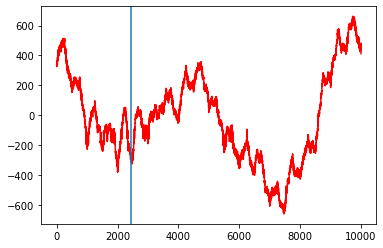

In [16]:
import matplotlib.pyplot as plt
plt.plot(con.data[:10000], 'r')
plt.axvline(events.ts[0])
plt.show()

### Let's check out the settings.xml file in Sample_Data

In [17]:
pathToPhaseCalc = cwd + '\\data\\Sample_Data\\104_CH1.continuous'
rawPhase = OpenEphys.load(pathToPhaseCalc)

conPhase = Con(rawPhase)
print('Phase calc loaded in')

Loading continuous data...
Phase calc loaded in


In [18]:
from scipy import signal
def myBandpass(lowcut, highcut, fs, data):
    nyq = 0.5 * fs
    low = lowcut /nyq
    high = highcut /nyq
    band = [low, high]
    order = 2
    b, a = signal.butter(order, band, btype='bandpass')
    
    filteredData = signal.lfilter(b, a, data)
    return filteredData

filteredData = myBandpass(4, 8, con.fs, con.data[:10000])

### So what is phase?
https://en.wikipedia.org/wiki/Phase_(waves)#/media/File:Oscillating_sine_wave.gif

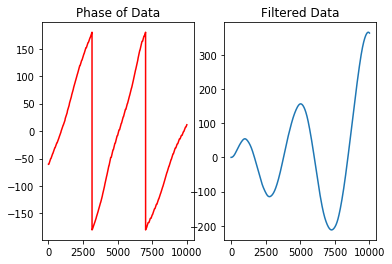

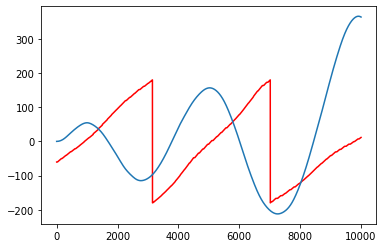

In [20]:
fig, ax = plt.subplots(1,2)

ax[0].plot(conPhase.data[:10000], 'r')
ax[0].set_title('Phase of Data')

ax[1].plot(filteredData)
ax[1].set_title('Filtered Data')

fig, ax = plt.subplots(1,1)
ax.plot(conPhase.data[:10000], 'r')
ax.plot(filteredData)


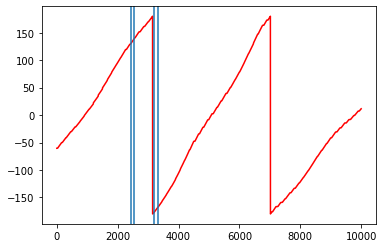

In [21]:
plt.plot(conPhase.data[:10000], 'r')
for ts in events.ts[0:4]:
    plt.axvline(ts)
plt.show()

### Challenge 2

Determine the average lag time between the pulse and the stim!

In [22]:
# Code here
lagSum = 0
numLags = 0 
for crossIndex in range(0, len(events.ts), 4):
    stimIndex = crossIndex + 2
    lagSum += events.ts[stimIndex] - events.ts[crossIndex]
    numLags += 1
    
avgLag = lagSum / numLags

lagSec = 1 / (conPhase.fs / avgLag)
print(lagSec, 'seconds')

0.025940717107262232 seconds


### Challenge 3

Determine the average phase at cross and stim times and plot a rose plot of the data

In [23]:
# Rose plot code here (I used google) https://stackoverflow.com/questions/22562364/circular-histogram-for-python
def rose_plot(ax, angles, bins=16, density=None, offset=0, lab_unit="degrees",
              start_zero=False, **param_dict):
    """
    Plot polar histogram of angles on ax. ax must have been created using
    subplot_kw=dict(projection='polar'). Angles are expected in radians.
    """
    # Wrap angles to [-pi, pi)
    angles = (angles + np.pi) % (2*np.pi) - np.pi

    # Set bins symetrically around zero
    if start_zero:
        # To have a bin edge at zero use an even number of bins
        if bins % 2:
            bins += 1
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    count, bin = np.histogram(angles, bins=bins)

    # Compute width of each bin
    widths = np.diff(bin)

    # By default plot density (frequency potentially misleading)
    if density is None or density is True:
        # Area to assign each bin
        area = count / angles.size
        # Calculate corresponding bin radius
        radius = (area / np.pi)**.5
    else:
        radius = count

    # Plot data on ax
    ax.bar(bin[:-1], radius, zorder=1, align='edge', width=widths,
           edgecolor='C0', fill=False, linewidth=1)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels, they are mostly obstructive and not informative
    ax.set_yticks([])

    if lab_unit == "radians":
        label = ['$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$',
                  r'$\pi$', r'$5\pi/4$', r'$3\pi/2$', r'$7\pi/4$']
        ax.set_xticklabels(label)

Text(0.5, 1.05, 'stim delivery')

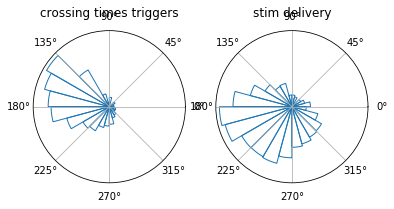

In [34]:
# Find average phases and plot them using a rose plot
import math
tsOffset = 1 + 1 - (conPhase.ts[1] - conPhase.ts[0])


stimPhase = []
crossPhase = []
for n in range(len(events.ts)-1):
    if events.nodeId[n] == 100 and events.eventId[n] == 1: # Stims
        ts = int(events.ts[n] * tsOffset)
        stimPhase.append(math.radians(conPhase.data[ts]))
    if events.nodeId[n] == 105 and events.eventId[n] == 1: # Crosses
        ts = int(events.ts[n] * tsOffset)
        crossPhase.append(math.radians(conPhase.data[ts]))

# Your code here

# Use this to plot
fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection='polar'))

rose_plot(ax[0], np.array(crossPhase), bins = 24)
rose_plot(ax[1], np.array(stimPhase), bins = 24)
ax[0].set_title('crossing times triggers')
ax[1].set_title('stim delivery')

#### What's the mean and std for the data?

In [46]:
# Print our the mean and std for crossing and stim times
from scipy import stats
stimMean = stats.circmean(stimPhase)
crossMean = stats.circmean(crossPhase)

stimStd = stats.circstd(stimPhase)
crossStd = stats.circstd(crossPhase)

print(math.degrees(crossStd), math.degrees(stimStd))

35.81679201236395 54.92380578207416


### Challenge 4

Let's write the phases to a csv file.

In [50]:
# Code here
pathToCSV = cwd + '\\data\\Sample_Data\\phases.csv' 

phasesFile = open(pathToCSV, 'w') #'r', 'a'

phasesFile.write('stim, cross \n')

# Option 1
#for n in range(len(stimPhase)):
#    phasesFile.write(str(stimPhase[n]) + ',' + str(crossPhase[n]) + '\n')
    
# Option 2
for stim, cross in zip(stimPhase, crossPhase):
    phasesFile.write(str(stim) + ',' + str(cross) + '\n')
    
phasesFile.close()

In [51]:
print(str(stimPhase[0]) + ',' + str(crossPhase[0]) + '\n')

-3.080069797456993,2.2700624916064247

